# Creating QUBO of Aircraft Loading Optimization (ALO)

In [44]:
import docplex
from docplex.mp.model import Model

from openqaoa.problems.converters import FromDocplex2IsingModel # function to translate docplex problems into Ising Hamiltonians

from openqaoa import QAOA, QUBO
from openqaoa.backends import create_device

In [160]:
containers = list(range(3))
containers_type = [2,3,1]
containers_mass = [1 , 1.2 , 1.2]

positions = list(range(3))

containers_proportion_of_mass_per_position = [0.5 if type == 3 else 1 for type in containers_type]
containers_occupacy_per_position = [0.5 if type == 2 else 1 for type in containers_type]

max_weight = 3
allBinaryVariables = list(range(len(containers) * len(positions)))


In [165]:
mdl = Model("ALO")
x = mdl.binary_var_list(len(allBinaryVariables), name="x")

# OBJECTIVE FUNCTION
mdl.minimize(-mdl.sum(
    t_i * m_i * x[len(positions) * i + j] 
    for j in positions
    for t_i,m_i,i in zip(containers_proportion_of_mass_per_position,containers_mass,containers)
))
'''
# NO OVERLAPS
for j in positions:
    mdl.add_constraint(mdl.sum(
        d_i * x[len(positions) * i + j]
        for d_i,i in zip(containers_occupacy_per_position,containers) 
        ) <= 1
    )
'''
# NO DUPLICATES
for i in containers:
    t_i = containers_proportion_of_mass_per_position[i]
    mdl.add_constraint(t_i * mdl.sum(
        x[len(positions) * i + j]
        for j in positions 
        ) <= 1
    )
'''
# CONTIGUITY FOR BIG CONTAINERS
for i in containers:
    if containers_type[i] != 3:
        continue
    mdl.add_constraint(
        mdl.sum(
            x[len(positions) * i + j] * x[len(positions) * i + (j+1)]
            for j in positions[:-1]
        ) 
        ==
        0.5 * mdl.sum(
            x[len(positions) * i + j]
            for j in positions
        )
    )

# MAXIMUM CAPACITY
mdl.add_constraint(
    mdl.sum(
        t_i * m_i * x[len(positions) * i + j] 
        for j in positions
        for t_i,m_i,i in zip(containers_proportion_of_mass_per_position,containers_mass,containers)
    ) <= max_weight
)'''
#mdl.add_constraint(mdl.sum(var * weights[i] for i, var in enumerate(x)) <= max_weight)


'\n# CONTIGUITY FOR BIG CONTAINERS\nfor i in containers:\n    if containers_type[i] != 3:\n        continue\n    mdl.add_constraint(\n        mdl.sum(\n            x[len(positions) * i + j] * x[len(positions) * i + (j+1)]\n            for j in positions[:-1]\n        ) \n        ==\n        0.5 * mdl.sum(\n            x[len(positions) * i + j]\n            for j in positions\n        )\n    )\n\n# MAXIMUM CAPACITY\nmdl.add_constraint(\n    mdl.sum(\n        t_i * m_i * x[len(positions) * i + j] \n        for j in positions\n        for t_i,m_i,i in zip(containers_proportion_of_mass_per_position,containers_mass,containers)\n    ) <= max_weight\n)'

In [162]:
mdl.name
print('Variables:')
for var in mdl.iter_variables():
    print(var)
print('\nobjective function:')
print(mdl.get_objective_expr(),'\n')
print('Constraints:')
for constraint in mdl.iter_constraints():
    print(constraint)

Variables:
x_0
x_1
x_2
x_3
x_4
x_5
x_6
x_7
x_8

objective function:
-x_0-x_1-x_2-0.600x_3-0.600x_4-0.600x_5-1.200x_6-1.200x_7-1.200x_8 

Constraints:
x_0+x_1+x_2 <= 1
0.500x_3+0.500x_4+0.500x_5 <= 1
x_6+x_7+x_8 <= 1


In [186]:
lambdas = [0.9603,0.08] # From the paper the lambdas found: https://arxiv.org/abs/2211.13914    
convertergWrapper = FromDocplex2IsingModel(mdl, unbalanced_const=True, strength_ineq=lambdas)
ising = convertergWrapper.ising_model
mdl_ising = convertergWrapper.qubo_docplex
#mdl.solve()
#print(ising.asdict())
mdl.name
print('Variables:')
for var in mdl_ising.iter_variables():
    print(var)
print(mdl_ising.objective_expr)
for var in mdl_ising.objective_expr.iter_terms():
    print(var)
# Iterar sobre los términos cuadráticos de la función objetivo
for quad_term in mdl.objective_expr.iter_quads():
    print(quad_term)

Variables:
x_0
x_1
x_2
x_3
x_4
x_5
x_6
x_7
x_8
0.080x_0^2+0.160x_0*x_1+0.160x_0*x_2+0.080x_1^2+0.160x_1*x_2+0.080x_2^2+0.020x_3^2+0.040x_3*x_4+0.040x_3*x_5+0.020x_4^2+0.040x_4*x_5+0.020x_5^2+0.080x_6^2+0.160x_6*x_7+0.160x_6*x_8+0.080x_7^2+0.160x_7*x_8+0.080x_8^2-0.200x_0-0.200x_1-0.200x_2-0.200x_3-0.200x_4-0.200x_5-0.400x_6-0.400x_7-0.400x_8-2.641
(docplex.mp.Var(type=B,name='x_0'), -0.1997)
(docplex.mp.Var(type=B,name='x_1'), -0.1997)
(docplex.mp.Var(type=B,name='x_2'), -0.1997)
(docplex.mp.Var(type=B,name='x_3'), -0.19984999999999997)
(docplex.mp.Var(type=B,name='x_4'), -0.19984999999999997)
(docplex.mp.Var(type=B,name='x_5'), -0.19984999999999997)
(docplex.mp.Var(type=B,name='x_6'), -0.39969999999999994)
(docplex.mp.Var(type=B,name='x_7'), -0.39969999999999994)
(docplex.mp.Var(type=B,name='x_8'), -0.39969999999999994)


In [164]:
q = QAOA()

qiskit_device = create_device(location='local', name='vectorized')

q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=3, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=500, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

q.compile(ising)
#q.optimize()
q.solve_brute_force(verbose=True)

Ground State energy: -3.65955, Solution: ['100111110', '010111110', '001111110', '100111101', '010111101', '001111101', '100111011', '010111011', '001111011']


states kept: 40


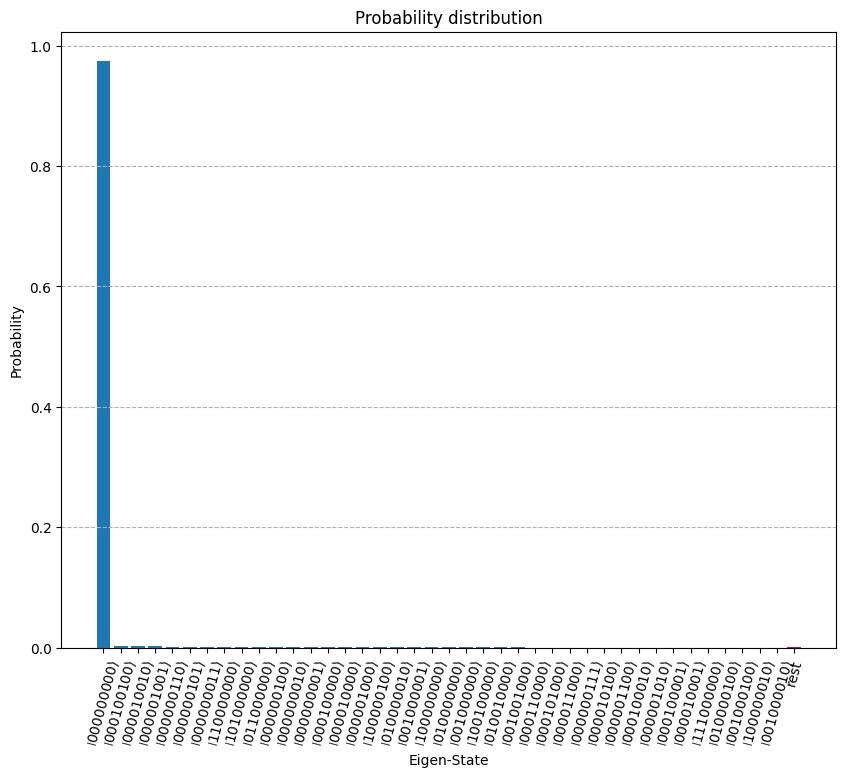

In [46]:
qresult=q.result
qresult.plot_probabilities()